In [1]:
%matplotlib inline


# DICS for power mapping

In this tutorial, we'll simulate two signals originating from two
locations on the cortex. These signals will be sinusoids, so we'll be looking
at oscillatory activity (as opposed to evoked activity).

We'll use dynamic imaging of coherent sources (DICS) :footcite:`GrossEtAl2001`
to map out spectral power along the cortex. Let's see if we can find our two
simulated sources.


In [2]:
# Author: Marijn van Vliet <w.m.vanvliet@gmail.com>
#
# License: BSD (3-clause)

## Setup
We first import the required packages to run this tutorial and define a list
of filenames for various things we'll be using.



In [3]:
import os.path as op
import numpy as np
from scipy.signal import welch, coherence, unit_impulse
from matplotlib import pyplot as plt

import mne
from mne.simulation import simulate_raw, add_noise
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.time_frequency import csd_morlet
from mne.beamformer import make_dics, apply_dics_csd

# We use the MEG and MRI setup from the MNE-sample dataset
data_path = sample.data_path(download=False)
subjects_dir = op.join(data_path, 'subjects')

# Filenames for various files we'll be using
meg_path = op.join(data_path, 'MEG', 'sample')
raw_fname = op.join(meg_path, 'sample_audvis_raw.fif')
fwd_fname = op.join(meg_path, 'sample_audvis-meg-eeg-oct-6-fwd.fif')
cov_fname = op.join(meg_path, 'sample_audvis-cov.fif')
fwd = mne.read_forward_solution(fwd_fname)

# Seed for the random number generator
rand = np.random.RandomState(42)

Reading forward solution from X:\neuroinformatics\mne-python\data\tutorials\MNE-sample-data\MEG\sample\sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame


## Data simulation

The following function generates a timeseries that contains an oscillator,
whose frequency fluctuates a little over time, but stays close to 10 Hz.
We'll use this function to generate our two signals.



In [4]:
sfreq = 50.  # Sampling frequency of the generated signal
n_samp = int(round(10. * sfreq))
times = np.arange(n_samp) / sfreq  # 10 seconds of signal
n_times = len(times)


def coh_signal_gen():
    """Generate an oscillating signal.

    Returns
    -------
    signal : ndarray
        The generated signal.
    """
    t_rand = 0.001  # Variation in the instantaneous frequency of the signal
    std = 0.1  # Std-dev of the random fluctuations added to the signal
    base_freq = 10.  # Base frequency of the oscillators in Hertz
    n_times = len(times)

    # Generate an oscillator with varying frequency and phase lag.
    signal = np.sin(2.0 * np.pi *
                    (base_freq * np.arange(n_times) / sfreq +
                     np.cumsum(t_rand * rand.randn(n_times))))

    # Add some random fluctuations to the signal.
    signal += std * rand.randn(n_times)

    # Scale the signal to be in the right order of magnitude (~100 nAm)
    # for MEG data.
    signal *= 100e-9

    return signal

Let's simulate two timeseries and plot some basic information about them.



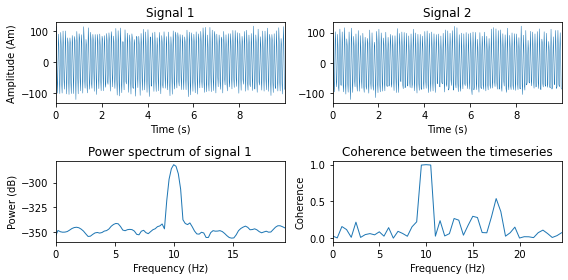

In [5]:
signal1 = coh_signal_gen()
signal2 = coh_signal_gen()

fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Plot the timeseries
ax = axes[0][0]
ax.plot(times, 1e9 * signal1, lw=0.5)
ax.set(xlabel='Time (s)', xlim=times[[0, -1]], ylabel='Amplitude (Am)',
       title='Signal 1')
ax = axes[0][1]
ax.plot(times, 1e9 * signal2, lw=0.5)
ax.set(xlabel='Time (s)', xlim=times[[0, -1]], title='Signal 2')

# Power spectrum of the first timeseries
f, p = welch(signal1, fs=sfreq, nperseg=128, nfft=256)
ax = axes[1][0]
# Only plot the first 100 frequencies
ax.plot(f[:100], 20 * np.log10(p[:100]), lw=1.)
ax.set(xlabel='Frequency (Hz)', xlim=f[[0, 99]],
       ylabel='Power (dB)', title='Power spectrum of signal 1')

# Compute the coherence between the two timeseries
f, coh = coherence(signal1, signal2, fs=sfreq, nperseg=100, noverlap=64)
ax = axes[1][1]
ax.plot(f[:50], coh[:50], lw=1.)
ax.set(xlabel='Frequency (Hz)', xlim=f[[0, 49]], ylabel='Coherence',
       title='Coherence between the timeseries')
fig.tight_layout()

Now we put the signals at two locations on the cortex. We construct a
:class:`mne.SourceEstimate` object to store them in.

The timeseries will have a part where the signal is active and a part where
it is not. The techniques we'll be using in this tutorial depend on being
able to contrast data that contains the signal of interest versus data that
does not (i.e. it contains only noise).



In [6]:
# The locations on the cortex where the signal will originate from. These
# locations are indicated as vertex numbers.
vertices = [[146374], [33830]]

# Construct SourceEstimates that describe the signals at the cortical level.
data = np.vstack((signal1, signal2))
stc_signal = mne.SourceEstimate(
    data, vertices, tmin=0, tstep=1. / sfreq, subject='sample')
stc_noise = stc_signal * 0.

Before we simulate the sensor-level data, let's define a signal-to-noise
ratio. You are encouraged to play with this parameter and see the effect of
noise on our results.



In [7]:
snr = 1.  # Signal-to-noise ratio. Decrease to add more noise.

Now we run the signal through the forward model to obtain simulated sensor
data. To save computation time, we'll only simulate gradiometer data. You can
try simulating other types of sensors as well.

Some noise is added based on the baseline noise covariance matrix from the
sample dataset, scaled to implement the desired SNR.



In [8]:
# Read the info from the sample dataset. This defines the location of the
# sensors and such.
info = mne.io.read_info(raw_fname)
info.update(sfreq=sfreq, bads=[])

# Only use gradiometers
picks = mne.pick_types(info, meg='grad', stim=True, exclude=())
mne.pick_info(info, picks, copy=False)

# Define a covariance matrix for the simulated noise. In this tutorial, we use
# a simple diagonal matrix.
cov = mne.cov.make_ad_hoc_cov(info)
cov['data'] *= (20. / snr) ** 2  # Scale the noise to achieve the desired SNR

# Simulate the raw data, with a lowpass filter on the noise
stcs = [(stc_signal, unit_impulse(n_samp, dtype=int) * 1),
        (stc_noise, unit_impulse(n_samp, dtype=int) * 2)]  # stacked in time
duration = (len(stc_signal.times) * 2) / sfreq
raw = simulate_raw(info, stcs, forward=fwd)
add_noise(raw, cov, iir_filter=[4, -4, 0.8], random_state=rand)

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000-10.000 sec
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000-10.000 sec
    2 STC iterations provided
Done
Adding noise to 204/213 channels (204 channels in cov)


TypeError: expected str, bytes or os.PathLike object, not NoneType

<RawArray | 213 x 1000 (20.0 s), ~4.8 MB, data loaded>

We create an :class:`mne.Epochs` object containing two trials: one with
both noise and signal and one with just noise



2 events found
Event IDs: [1 2]
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
3 projection items activated
Loading data for 2 events and 500 original time points ...
0 bad epochs dropped


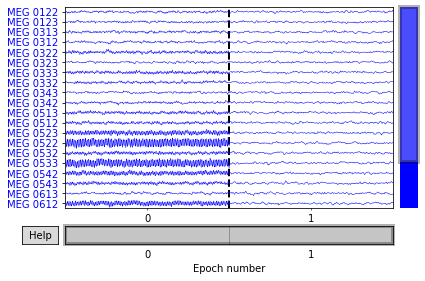

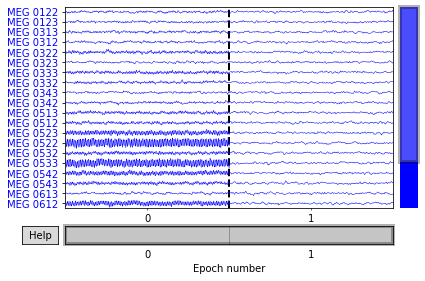

In [9]:
events = mne.find_events(raw, initial_event=True)
tmax = (len(stc_signal.times) - 1) / sfreq
epochs = mne.Epochs(raw, events, event_id=dict(signal=1, noise=2),
                    tmin=0, tmax=tmax, baseline=None, preload=True)
assert len(epochs) == 2  # ensure that we got the two expected events

# Plot some of the channels of the simulated data that are situated above one
# of our simulated sources.
picks = mne.pick_channels(epochs.ch_names,
                          mne.read_vectorview_selection('Left-frontal'))
epochs.plot(picks=picks)

## Power mapping
With our simulated dataset ready, we can now pretend to be researchers that
have just recorded this from a real subject and are going to study what parts
of the brain communicate with each other.

First, we'll create a source estimate of the MEG data. We'll use both a
straightforward MNE-dSPM inverse solution for this, and the DICS beamformer
which is specifically designed to work with oscillatory data.



Computing the inverse using MNE-dSPM:



In [14]:
# Compute the inverse operator
fwd = mne.read_forward_solution(fwd_fname)
inv = make_inverse_operator(epochs.info, fwd, cov)

# Apply the inverse model to the trial that also contains the signal.
s = apply_inverse(epochs['signal'].average(), inv)

# Take the root-mean square along the time dimension and plot the result.
s_rms = np.sqrt((s ** 2).mean())
title = 'MNE-dSPM inverse (RMS)'
brain = s_rms.plot('sample', subjects_dir=subjects_dir, hemi='both', figure=1,
                   size=600, time_label=title, title=title)

# Indicate the true locations of the source activity on the plot.
brain.add_foci(vertices[0][0], coords_as_verts=True, hemi='lh')
brain.add_foci(vertices[1][0], coords_as_verts=True, hemi='rh')

# Rotate the view and add a title.
brain.show_view(view={'azimuth': 0, 'elevation': 0, 'distance': 550,
                'focalpoint': [0, 0, 0]})

Reading forward solution from X:\neuroinformatics\mne-python\data\tutorials\MNE-sample-data\MEG\sample\sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based

We will now compute the cortical power map at 10 Hz. using a DICS beamformer.
A beamformer will construct for each vertex a spatial filter that aims to
pass activity originating from the vertex, while dampening activity from
other sources as much as possible.

The :func:`mne.beamformer.make_dics` function has many switches that offer
precise control
over the way the filter weights are computed. Currently, there is no clear
consensus regarding the best approach. This is why we will demonstrate two
approaches here:

 1. The approach as described in :footcite:`vanVlietEtAl2018`, which first
    normalizes the forward solution and computes a vector beamformer.
 2. The scalar beamforming approach based on
    :footcite:`SekiharaNagarajan2008`, which uses weight normalization
    instead of normalizing the forward solution.



In [11]:
# Estimate the cross-spectral density (CSD) matrix on the trial containing the
# signal.
csd_signal = csd_morlet(epochs['signal'], frequencies=[10])

# Compute the spatial filters for each vertex, using two approaches.
filters_approach1 = make_dics(
    info, fwd, csd_signal, reg=0.05, pick_ori='max-power', depth=1.,
    inversion='single', weight_norm=None, real_filter=True)
print(filters_approach1)

filters_approach2 = make_dics(
    info, fwd, csd_signal, reg=0.05, pick_ori='max-power', depth=None,
    inversion='matrix', weight_norm='unit-noise-gain', real_filter=True)
print(filters_approach2)

# You can save these to disk with:
# filters_approach1.save('filters_1-dics.h5')

# Compute the DICS power map by applying the spatial filters to the CSD matrix.
power_approach1, f = apply_dics_csd(csd_signal, filters_approach1)
power_approach2, f = apply_dics_csd(csd_signal, filters_approach2)

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
Identifying common channels ...
Dropped the following channels:
['EEG 060', 'MEG 0141', 'EEG 030', 'MEG 0941', 'EEG 022', 'MEG 0441', 'EEG 041', 'MEG 1311', 'MEG 0721', 'MEG 2111', 'EEG 001', 'MEG 1511', 'EEG 024', 'MEG 2331', 'MEG 2531', 'MEG 1041', 'EEG 010', 'EEG 048', 'EEG 056', 'MEG 1131', 'EEG 058', 'EEG 045', 'MEG 0411', 'EEG 004', 'EEG 015', 'MEG 2541', 'EEG 006', 'STI 002', 'MEG 0531', 'MEG 0341', 'EEG 054', 'MEG 1321', 'MEG 2411', 'MEG 0711', 'MEG 0821', 'MEG 0621', 'STI 005', 'MEG 2311', 'EEG 034', 'EEG 036', 'EEG 018', 'STI 004', 'EEG 016', 'MEG 1411', 'MEG 2211', 'EEG 017', 'EEG 007', 'MEG 2231', 'EEG 028', 'MEG 2441', 'MEG 1341', 'MEG 1141', 'EEG 011', 'MEG 1621', 'MEG 1011', 'EEG 049', 'MEG 1811', 'EEG 012', 'MEG 0221', 'MEG 1211', 'EEG 050', 'EEG 052', 'MEG 2011', 'MEG 2041', 'EEG 025', 'MEG 1931', 'MEG 1741', 'MEG 2611', 'MEG 0311', 'MEG 1221', 'MEG 1031', 'STI 006', 'MEG 0911', 'MEG 1711', 'EEG 043', 'MEG 2521', 'MEG 1331', 'EEG 047', 'STI 003', 'EEG 008', 'EEG

Plot the DICS power maps for both approaches, starting with the first:



In [12]:
def plot_approach(power, n):
    """Plot the results on a brain."""
    title = 'DICS power map, approach %d' % n
    brain = power_approach1.plot(
        'sample', subjects_dir=subjects_dir, hemi='both',
        size=600, time_label=title, title=title)
    # Indicate the true locations of the source activity on the plot.
    brain.add_foci(vertices[0][0], coords_as_verts=True, hemi='lh', color='b')
    brain.add_foci(vertices[1][0], coords_as_verts=True, hemi='rh', color='b')
    # Rotate the view and add a title.
    brain.show_view(view={'azimuth': 0, 'elevation': 0, 'distance': 550,
                          'focalpoint': [0, 0, 0]})
    return brain


brain1 = plot_approach(power_approach1, 1)

Using control points [5.31458766e-25 6.31530886e-25 2.17335209e-24]


Now the second:



In [13]:
brain2 = plot_approach(power_approach2, 2)

Using control points [5.31458766e-25 6.31530886e-25 2.17335209e-24]


Excellent! All methods found our two simulated sources. Of course, with a
signal-to-noise ratio (SNR) of 1, is isn't very hard to find them. You can
try playing with the SNR and see how the MNE-dSPM and DICS approaches hold up
in the presence of increasing noise. In the presence of more noise, you may
need to increase the regularization parameter of the DICS beamformer.

## References
.. footbibliography::

